# AVI-DYS Time Series Classification

## Import Libraries

In [26]:
import os
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set User specific parameters

In [27]:
IDs = ['001', '003', '004', '005', '115', '116', '117', '118', '120', '121',
       '122', '123', '125', '126', '127', '128', '129', '130', '131', '132',
       '133', '135', '138', '151', '152', '301', '303', '304', '305', '306',
       '307', '308', '309']

data_path = "C:\\Users\\zacha\\Data\\AVI-DYS\\Results\\Post-Processing\\5-Concatenated"

## Format the DIS Scores

Initialize an output DataFrame for the DIS scores (y)

In [28]:
# Make a list of columns for each DIS type of DIS score
cols = ['Dystonia-Duration', 'Dystonia-Amplitude',
       'Choreoathetosis-Duration', 'Choreoathetosis-Amplitude']

# Create a list of iterables for the Multindex
iterables = [IDs, ["11", "12"]]

# Create the Multindex
index = pd.MultiIndex.from_product(iterables, names=["ID", "Side Code"])

# Make a an empty data frame for the DIS scores (Y)
Y = pd.DataFrame(index=index, columns=cols)

# Reset the multindex as columns for indexing
Y.reset_index(inplace=True)

Put the DIS scores into a tidy format

In [29]:
# Read in the meta data
df = pd.read_excel("C:\\Users\\zacha\\Repos\\AVI-DYS\\DIS-Included.xlsx")

# Convert the scores from the meta data from wide to long (one row = one observation left or right)
for idx, i in enumerate(IDs):
    Y['Dystonia-Duration'][idx*2] = df['Dystonia-Right-Duration-11'][idx]
    Y['Dystonia-Duration'][idx*2+1] = df['Dystonia-Left-Duration-12'][idx]
    Y['Dystonia-Amplitude'][idx*2] = df['Dystonia-Right-Amplitude-11'][idx]
    Y['Dystonia-Amplitude'][idx*2+1] = df['Dystonia-Left-Amplitude-12'][idx]
    Y['Choreoathetosis-Duration'][idx*2] = df['Choreoathetosis-Right-Duration-11'][idx]
    Y['Choreoathetosis-Duration'][idx*2+1] = df['Choreoathetosis-Left-Duration-12'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2] = df['Choreoathetosis-Right-Amplitude-11'][idx]
    Y['Choreoathetosis-Amplitude'][idx*2+1] = df['Choreoathetosis-Left-Amplitude-12'][idx]

# Collapse scores: DIS 1 & 2 to 1, DIS 3 & 4 to 2
for c in cols:
    Y.loc[Y[c] == 2, c] = 1
    Y.loc[Y[c] == 3, c] = 2
    Y.loc[Y[c] == 4, c] = 2

## Create the 3D numpy array

Initialize an output DataFrame for the Data (X)

In [30]:
# Make a list of columns based on the movement and skeleton data
cols = ['HLX_x', 'HLX_y', 'D1M_x', 'D1M_y', 'D3M_x', 'D3M_y', 'ANK_x',
       'ANK_y', 'KNE_x', 'KNE_y', 'KNE_ANK_length',
       'KNE_ANK_orientation', 'ANK_D3M_length', 'ANK_D3M_orientation',
       'ANK_D1M_length', 'ANK_D1M_orientation', 'D1M_HLX_length',
       'D1M_HLX_orientation']

# Create an empty dataframe
df = pd.DataFrame(columns=cols)

Enter each feature into the DataFrame as a single cell

In [31]:
for i in IDs:
   
    right_data = pd.read_csv(os.path.join(data_path,f'{i}-right-data.csv'))
    left_data = pd.read_csv(os.path.join(data_path,f'{i}-left-data.csv'))    
    
    right_flat = pd.DataFrame(index=[f'{i}-right'])
    for c in right_data.columns:
        right_flat[c] = [right_data[c].to_numpy()]  

    left_flat = pd.DataFrame(index=[f'{i}-left'])
    for c in left_data.columns:
        left_flat[c] = [left_data[c].to_numpy()]    
    
    df = pd.concat([df, right_flat, left_flat,])

Convert the DataFrame into a 3D numpy array (observations, features, time points)

In [32]:
# Extract the values from the DataFrame
data = df.values

# Create an empty 3D NumPy array
num_rows, num_columns = df.shape
num_elements = df.iloc[0, 0].shape[0]
X = np.empty((num_rows, num_columns, num_elements))

# Populate the 3D array with the values from the DataFrame
for i in range(num_rows):
    for j in range(num_columns):
        X[i, j] = data[i, j]

## HIVE-COTE v2.0

In [33]:
# Create a list of DIS categories for the confusion matrices and the classifaction report
target_names = ['DIS-0','DIS-1 & 2','DIS 3 & 4']
class_names = ['DIS-0','DIS-1 & 2','DIS 3 & 4']

### Fit models using a 70-30 stratified train-test split

#### Predict the Dystonia Duration Scores

In [34]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  14:39:27 29/05/2023
STC train estimate  14:39:54 29/05/2023
STC weight = 0.4656965919933105
DrCIF  14:40:18 29/05/2023
DrCIF train estimate  14:40:22 29/05/2023
DrCIF weight = 0.33515125553439284
Arsenal  14:40:53 29/05/2023
Arsenal train estimate  14:41:09 29/05/2023
Arsenal weight = 0.33515125553439284
TDE  14:41:29 29/05/2023
TDE train estimate  14:41:29 29/05/2023
TDE weight = 0.37512730443358916


Create the confusion matrix

Confusion Matrix
[[ 1  0  2]
 [ 0  0  1]
 [ 0  0 16]]


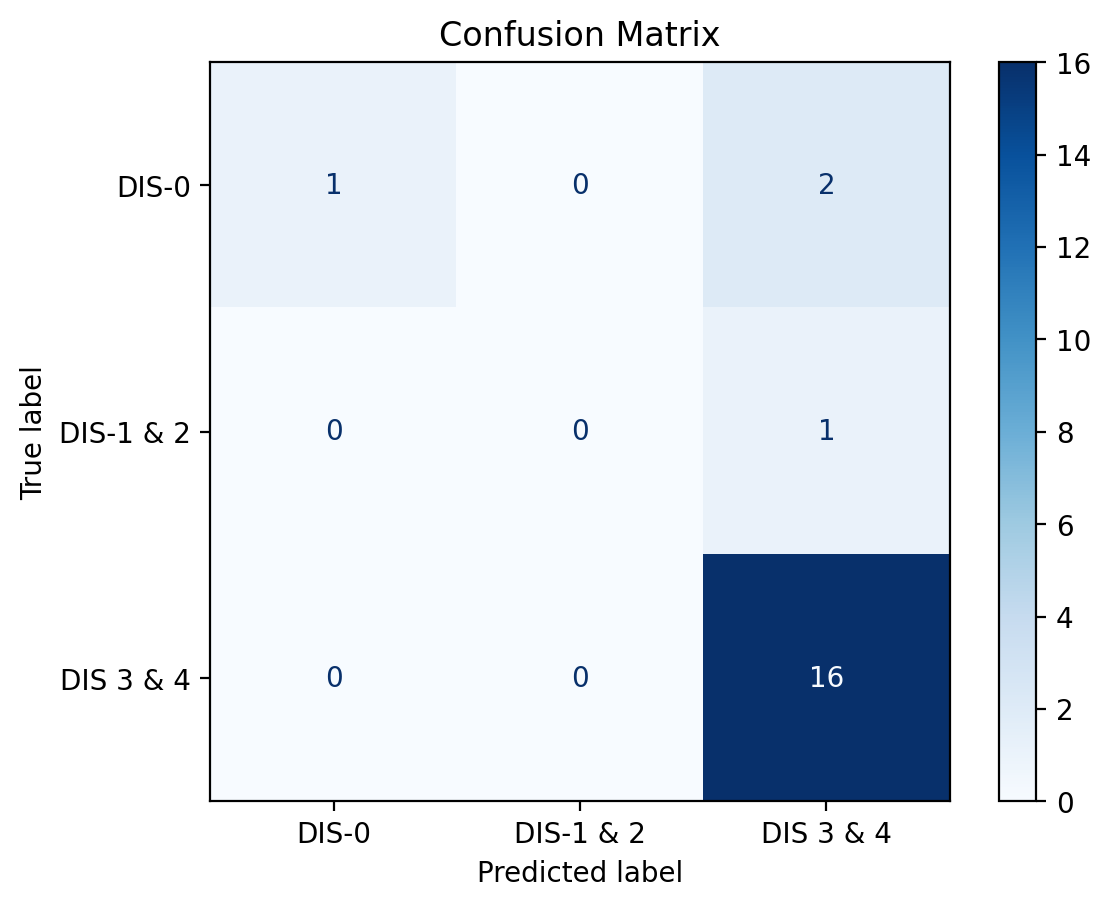

In [35]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.00      0.00      0.00         1
           2       0.84      1.00      0.91        16

    accuracy                           0.85        20
   macro avg       0.61      0.44      0.47        20
weighted avg       0.82      0.85      0.81        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict the Dystonia Amplitude Scores

In [37]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Dystonia-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  14:43:00 29/05/2023
STC train estimate  14:43:32 29/05/2023
STC weight = 0.33515125553439284
DrCIF  14:43:54 29/05/2023
DrCIF train estimate  14:43:59 29/05/2023
DrCIF weight = 0.41857720098198625
Arsenal  14:44:30 29/05/2023
Arsenal train estimate  14:44:46 29/05/2023
Arsenal weight = 0.2984587676573482
TDE  14:45:07 29/05/2023
TDE train estimate  14:45:07 29/05/2023
TDE weight = 0.2984587676573482


Create the confusion matrix

Confusion Matrix
[[ 2  0  1]
 [ 0  0  3]
 [ 1  0 13]]


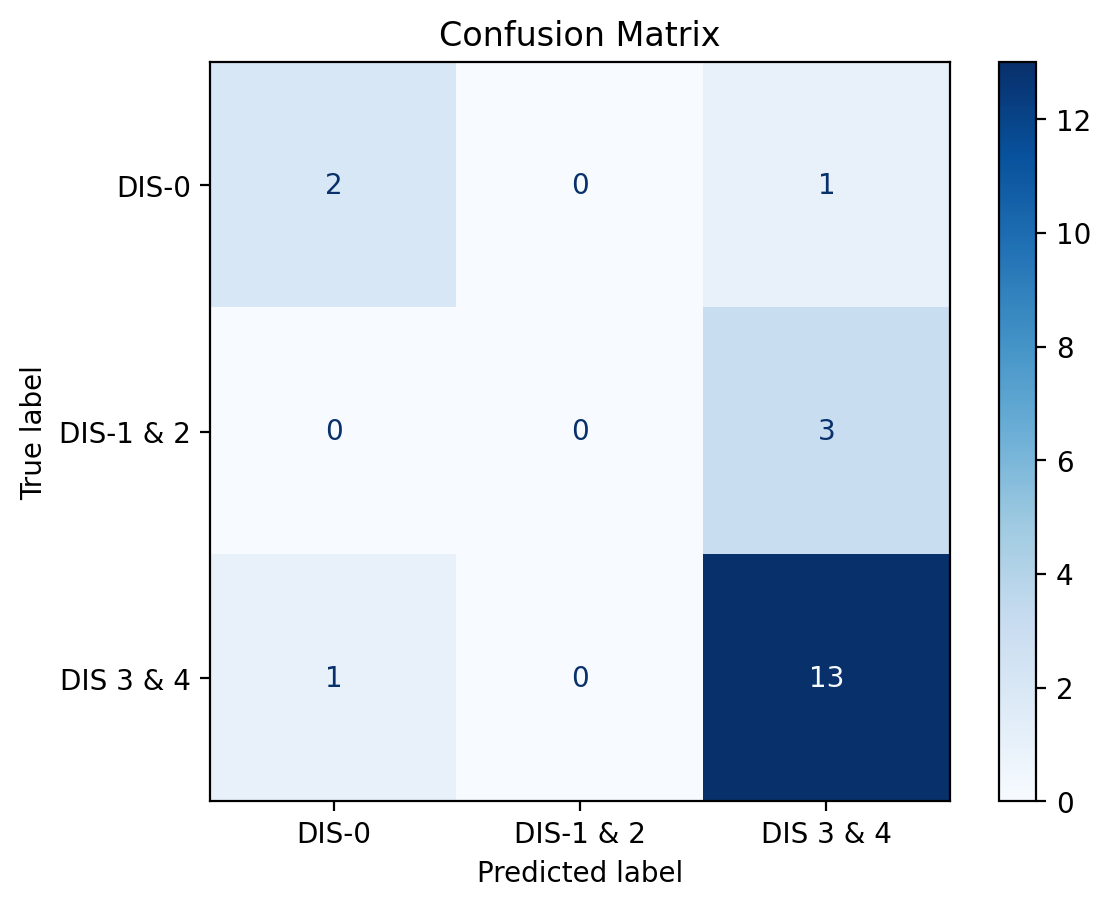

In [38]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         3
           2       0.76      0.93      0.84        14

    accuracy                           0.75        20
   macro avg       0.48      0.53      0.50        20
weighted avg       0.64      0.75      0.69        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Predict the Choreoathetosis Duration Scores

In [40]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Duration'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  14:46:48 29/05/2023
STC train estimate  14:47:30 29/05/2023
STC weight = 0.0625
DrCIF  14:47:53 29/05/2023
DrCIF train estimate  14:47:58 29/05/2023
DrCIF weight = 0.0523189954295475
Arsenal  14:48:30 29/05/2023
Arsenal train estimate  14:48:46 29/05/2023
Arsenal weight = 0.0872426217030385
TDE  14:49:07 29/05/2023
TDE train estimate  14:49:07 29/05/2023
TDE weight = 0.0872426217030385


Create the confusion matrix

Confusion Matrix
[[2 3 0]
 [3 5 2]
 [2 2 1]]


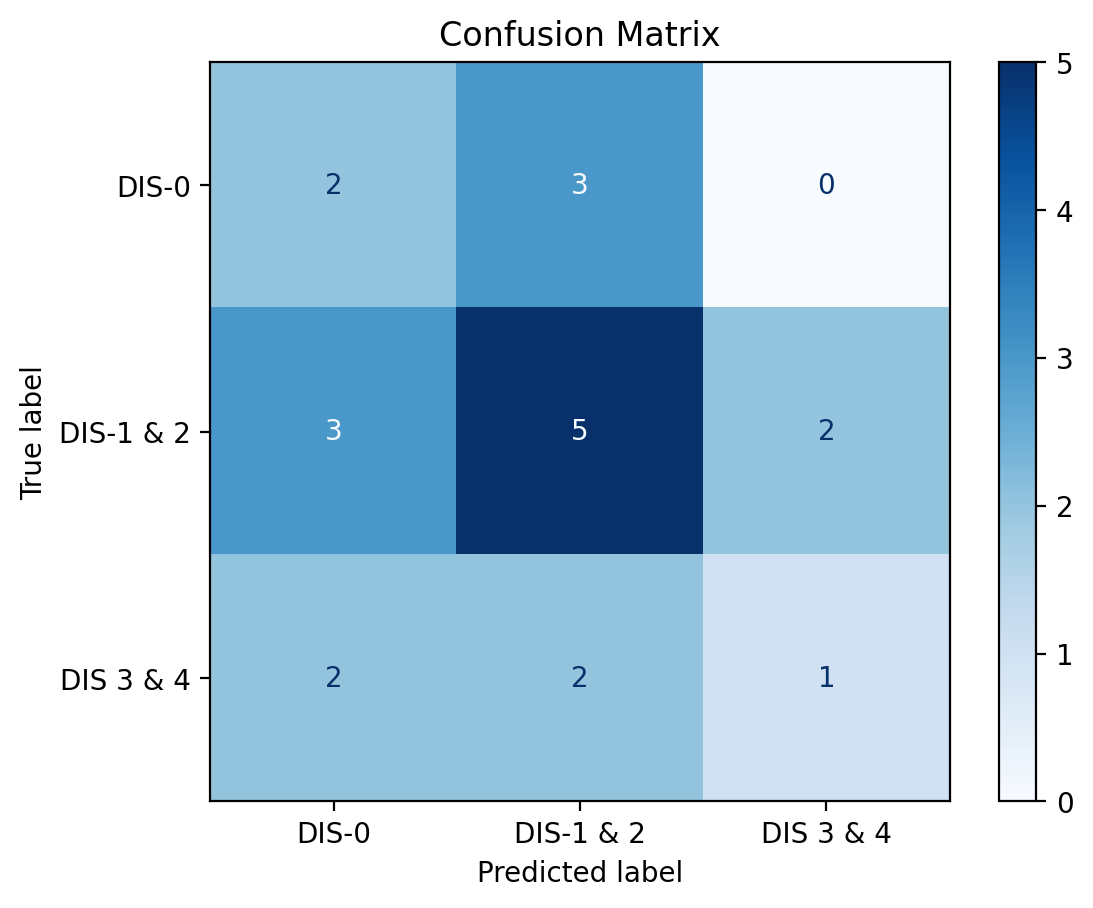

In [41]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.50      0.50      0.50        10
           2       0.33      0.20      0.25         5

    accuracy                           0.40        20
   macro avg       0.37      0.37      0.36        20
weighted avg       0.40      0.40      0.40        20



#### Predict the Choreoathetosis Amplitude Scores

In [43]:
# Select the relevant data from the scores DataFrame (Y)
y = Y['Choreoathetosis-Amplitude'].astype(str).to_numpy()

# Split the data using a 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# Create the classifier
hc2 =HIVECOTEV2(
      stc_params=None,
      drcif_params=None,
      arsenal_params=None,
      tde_params=None,
      time_limit_in_minutes=2,
      save_component_probas=False,
      verbose=1,
      n_jobs=-1,
      random_state=42,
)

# Fit the classifier
hc2.fit(X_train,y_train)

# Predict the test labels
y_pred = hc2.predict(X_test)

STC  14:51:00 29/05/2023
STC train estimate  14:51:40 29/05/2023
STC weight = 0.04343560271725729
DrCIF  14:52:03 29/05/2023
DrCIF train estimate  14:52:08 29/05/2023
DrCIF weight = 0.029106036999581905
Arsenal  14:52:39 29/05/2023
Arsenal train estimate  14:52:55 29/05/2023
Arsenal weight = 0.029106036999581905
TDE  14:53:16 29/05/2023
TDE train estimate  14:53:16 29/05/2023
TDE weight = 0.11869262366844034


Create the confusion matrix

Confusion Matrix
[[ 1  4  0]
 [ 1 10  0]
 [ 0  4  0]]


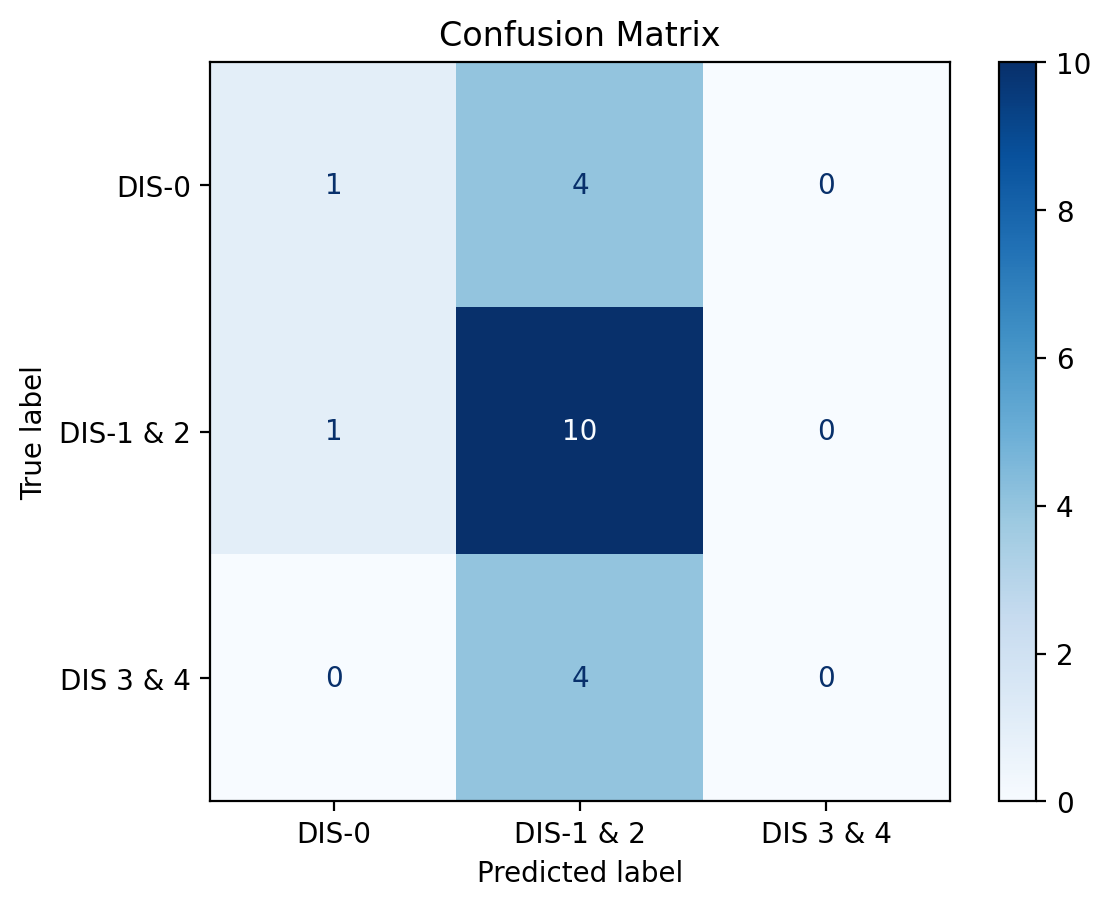

In [44]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize=None,
)
disp.ax_.set_title('Confusion Matrix')

print('Confusion Matrix')
print(disp.confusion_matrix)

Print the classification report

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.56      0.91      0.69        11
           2       0.00      0.00      0.00         4

    accuracy                           0.55        20
   macro avg       0.35      0.37      0.33        20
weighted avg       0.43      0.55      0.45        20



c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\zacha\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
